In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-03 05:08:04.602886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 05:08:04.669035: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-03 05:08:05.108535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_056


In [2]:
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
sub = pd.read_csv(f'/kaggle/output/{CFG["regressor"]["execution"]["best_exp_id"]}/submission.csv')
sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes
0,4995,5039.0,5051.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5
1,10928,10895.0,10907.5,038441c925bb,0.754868,wakeup,33.655094,37.0,2337.5
2,20288,20375.0,20387.5,038441c925bb,0.630360,onset,-86.351067,-131.0,2937.5
3,27432,27455.0,27467.5,038441c925bb,0.880441,wakeup,-22.161205,37.0,2337.5
4,39989,40007.0,40019.5,038441c925bb,0.879920,onset,-17.894793,-11.0,297.5


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [3]:
# 周辺に予測を撒く
dfs = []
for level, diff in enumerate([0, -1, 1, -2, 2, -3, 3, -5, 5, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["key_step"] += CFG["feature"]["agg_freq"] * diff
    tmp["sub_step_before_modify"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub.head()

,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes,level
0,4275,4319.0,4331.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,11
1,4635,4679.0,4691.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,9
2,4875,4919.0,4931.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,7
3,4923,4967.0,4979.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,5
4,4947,4991.0,5003.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,3


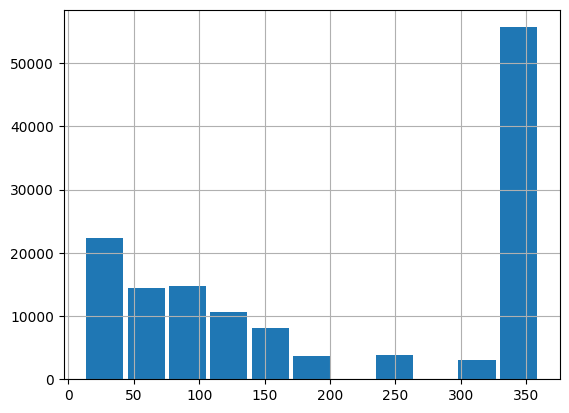

series_id                 5331576
step                      5331576
oof_stage2                5331576
minutes                    878007
target                     136497
sub_step                   136497
key_step                   136497
sub_step_before_modify     136497
event                      136497
level                      136497
score                      136379
oof_regressor              136497
dtype: int64
247.3784220463602


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,score,oof_regressor
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.full(len(sub_df), 360)
    for thresh in thresholds:
        for step in label_df["step"].values:
            for idx, sub_step in enumerate(sub_df["step"].values):
                dist = abs(step - sub_step)
                if dist < thresh:
                    targets[idx] = min(targets[idx], thresh)
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "key_step", "sub_step_before_modify",
         "event", "level", "score", "oof_regressor"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [5]:
from tqdm import tqdm

# スコアの理論値(targetを完璧に当てれた場合)
ideal_sub = sub.copy()
dfs = []
for (series_id, event), df in tqdm(ideal_sub.groupby(["series_id", "event"])):
    used = np.zeros(df["sub_step"].max() + max(thresholds), dtype=bool)
    df = df.sort_values("target").reset_index(drop=True)
    for idx, row in df.iterrows():
        if used[row["sub_step"]]:
            continue
        step = row["sub_step"]
        diff = int(360 - row["target"])
        if diff > 0:
            used[step - diff: step + diff] = True
        dfs.append(row)
ideal_sub = pd.DataFrame(dfs).reset_index(drop=True)
ideal_sub["score"] = 360 - ideal_sub["target"]
ideal_sub["step"] = ideal_sub["sub_step"]

labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, ideal_sub)
print(f"score: {score:.4f}")
display(ap_table)

100%|██████████| 538/538 [00:03<00:00, 150.76it/s]


score: 0.9208


event   tolerance
onset   12           0.768942
        36           0.865373
        60           0.888332
        90           0.914214
        120          0.938844
        150          0.945475
        180          0.953544
        240          0.956177
        300          0.958771
        360          0.959463
wakeup  12           0.753859
        36           0.874635
        60           0.901752
        90           0.929287
        120          0.957447
        150          0.964247
        180          0.969388
        240          0.970803
        300          0.972800
        360          0.973028
dtype: float64

In [6]:
# 再現率
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    for thresh in thresholds:
        targets = np.zeros(len(label_df))
        for idx, step in enumerate(label_df["step"].values):           
            min_dist = thresh
            min_idx = -1            
            for sub_step in sub_df["step"].values:    
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[idx] = True
        label_df["target"] = targets
        label_df["threshold"] = thresh
        dfs.append(label_df.copy())
recall_df = pd.concat(dfs).reset_index(drop=True)
print(recall_df["target"].mean())
display(recall_df.groupby(["event", "threshold"])["target"].mean())

0.921679707876891


event   threshold
onset   12           0.769150
        36           0.865790
        60           0.888958
        90           0.914840
        120          0.939470
        150          0.946149
        180          0.954289
        240          0.957003
        300          0.959716
        360          0.964517
wakeup  12           0.754276
        36           0.875052
        60           0.902169
        90           0.929704
        120          0.957864
        150          0.964748
        180          0.969962
        240          0.971423
        300          0.973509
        360          0.974969
Name: target, dtype: float64

In [7]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:22<00:00,  1.37it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4331.5,0.999193,NaN,360.0,4275.0,4331.5,4319.0,onset,11.0,...,0.0,0.960272,-0.002529,0.739955,0.0,0.998246,-0.000057,0.928339,0.0,2
1,038441c925bb,4691.5,0.998122,NaN,360.0,4635.0,4691.5,4679.0,onset,9.0,...,0.0,0.959926,-0.003268,0.719675,0.0,0.998064,-0.000062,0.921905,0.0,2
2,038441c925bb,4931.5,0.978979,1257.5,120.0,4875.0,4931.5,4919.0,onset,7.0,...,0.0,0.956779,-0.003403,0.711052,0.0,0.997368,-0.000110,0.908498,0.0,2
3,038441c925bb,4979.5,0.655212,1497.5,90.0,4923.0,4979.5,4967.0,onset,5.0,...,0.0,0.955628,-0.003881,0.709298,0.0,0.997191,-0.000128,0.904553,0.0,2
4,038441c925bb,5003.5,0.194866,1617.5,60.0,4947.0,5003.5,4991.0,onset,3.0,...,0.0,0.954305,-0.004250,0.707743,0.0,0.997088,-0.000129,0.902806,0.0,2


(136497, 1390)

In [8]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["oof_ranker"] = trn_oof
train["score"] = train["oof_ranker"]
train["key_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "key_step", "step", "event", "level", "series_id"]]

dfs = []
for (series_id, event), df in tqdm(sub.groupby(["series_id", "event"])):
    used = np.zeros(df["step"].max() + max(thresholds), dtype=bool)
    df = df.sort_values("score").reset_index(drop=True)
    for idx, row in df.iterrows():
        if used[row["step"]]:
            continue
        step = row["step"]
        diff = int(360 - row["score"])
        if diff > 0:
            used[step - diff: step + diff] = True
        dfs.append(row)
sub = pd.DataFrame(dfs).reset_index(drop=True)
sub["score"] = 360 - ideal_sub["score"]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:243.71903
[100]	eval-rmse:115.82810
[200]	eval-rmse:84.31885
[300]	eval-rmse:78.66916
[400]	eval-rmse:77.65158
[500]	eval-rmse:77.42991
[600]	eval-rmse:77.44142
[620]	eval-rmse:77.44877


 20%|██        | 1/5 [00:19<01:17, 19.45s/it]

== fold 1 ==
[0]	eval-rmse:242.50476
[100]	eval-rmse:112.77847
[200]	eval-rmse:81.25003
[300]	eval-rmse:76.06018
[400]	eval-rmse:75.33799
[500]	eval-rmse:75.17130
[600]	eval-rmse:75.14798
[700]	eval-rmse:75.15702
[800]	eval-rmse:75.13814
[900]	eval-rmse:75.08379
[1000]	eval-rmse:75.08362
[1009]	eval-rmse:75.08502


 40%|████      | 2/5 [00:47<01:14, 24.76s/it]

== fold 2 ==
[0]	eval-rmse:244.38883
[100]	eval-rmse:114.22761
[200]	eval-rmse:82.57879
[300]	eval-rmse:77.32920
[400]	eval-rmse:76.47871
[500]	eval-rmse:76.36497
[600]	eval-rmse:76.33811
[700]	eval-rmse:76.36720
[715]	eval-rmse:76.36755


 60%|██████    | 3/5 [01:09<00:46, 23.20s/it]

== fold 3 ==
[0]	eval-rmse:244.08332
[100]	eval-rmse:115.76439
[200]	eval-rmse:84.24595
[300]	eval-rmse:79.13473
[400]	eval-rmse:78.64053
[500]	eval-rmse:78.73985
[536]	eval-rmse:78.82351


 80%|████████  | 4/5 [01:26<00:20, 20.71s/it]

== fold 4 ==
[0]	eval-rmse:248.46636
[100]	eval-rmse:119.87377
[200]	eval-rmse:87.98535
[300]	eval-rmse:82.10206
[400]	eval-rmse:81.05522
[500]	eval-rmse:80.87990
[600]	eval-rmse:80.92468
[619]	eval-rmse:80.92728


100%|██████████| 538/538 [00:03<00:00, 149.04it/s]


In [20]:

sub = train[["score", "key_step", "step", "event", "level", "series_id", "target"]]
dfs = []
for (series_id, event), df in tqdm(sub.groupby(["series_id", "event"])):
    used = np.zeros(df["step"].max() + max(thresholds), dtype=bool)
    df = df.sort_values("score").reset_index(drop=True)
    for idx, row in df.iterrows():
        if used[row["step"]]:
            continue
        step = row["step"]
        diff = int(360 - row["score"])
        if diff > 0:
            used[step - diff: step + diff] = True
            dfs.append(row)
sub = pd.DataFrame(dfs).reset_index(drop=True)
sub["score"] = 360 - ideal_sub["score"]

100%|██████████| 538/538 [00:03<00:00, 157.10it/s]


In [21]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.1323


event   tolerance
onset   12           0.015669
        36           0.072457
        60           0.104323
        90           0.128857
        120          0.145221
        150          0.154848
        180          0.164398
        240          0.168196
        300          0.171384
        360          0.187648
wakeup  12           0.016650
        36           0.071678
        60           0.103974
        90           0.128137
        120          0.144598
        150          0.157094
        180          0.166319
        240          0.171754
        300          0.176642
        360          0.196430
dtype: float64